Задача 2. Анализ климатических условий
В датасете представлены наблюдения за изменением температуры, влажности, скорости ветра и атмосферного давления в Индии с 1 января 2013 по 24 апреля 2017 года.
Источник данных:
https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data

Вариант 2. Сделать прогноз колонки humidity с помощью методов 

In [1]:
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Читаем датасет из файла
df = pd.read_csv("DailyDelhiClimateTrain.csv")
df

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [3]:
#У нас нет пустых значений
df.isnull().mean()

date            0.0
meantemp        0.0
humidity        0.0
wind_speed      0.0
meanpressure    0.0
dtype: float64

dataset = pd.DataFrame(df["humidity"])
import matplotlib.pyplot as plt
row = dataset.iloc[1000,:].values #пример выбора значений 1000-ой строки
#выводим график humidity нашего датасета
plt.plot(dataset)
plt.show()

#импортируем ARIMA и обучаем
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(dataset, order=(1,1,1), seasonal_order=(1,1,1,10))
fitted = model.fit()

from statsmodels.graphics.tsaplots import plot_acf
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':90})
fig, axes = plt.subplots(1, 2)
axes[0].plot(dataset)
plot_acf(dataset, ax=axes[1]);

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(10,10), 'figure.dpi':90})
fig, axes = plt.subplots(3, 1)
axes[0].plot(dataset)
plot_acf(dataset, ax=axes[1]);
plot_pacf(dataset, ax=axes[2], method='ywm');

dataset_diff = dataset.diff().iloc[1:]

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(10,10), 'figure.dpi':90})
fig, axes = plt.subplots(3, 1)
axes[0].plot(dataset_diff)
plot_acf(dataset_diff, ax=axes[1]);
plot_pacf(dataset_diff, ax=axes[2], method='ywm');

from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(dataset_diff, order=(1,1,5), seasonal_order=(1,1,1,30))
fitted = model.fit()

In [4]:
df_test = pd.read_csv("DailyDelhiClimateTrain.csv")

In [5]:
row = df_test["humidity"]
training_time_steps = 1000

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


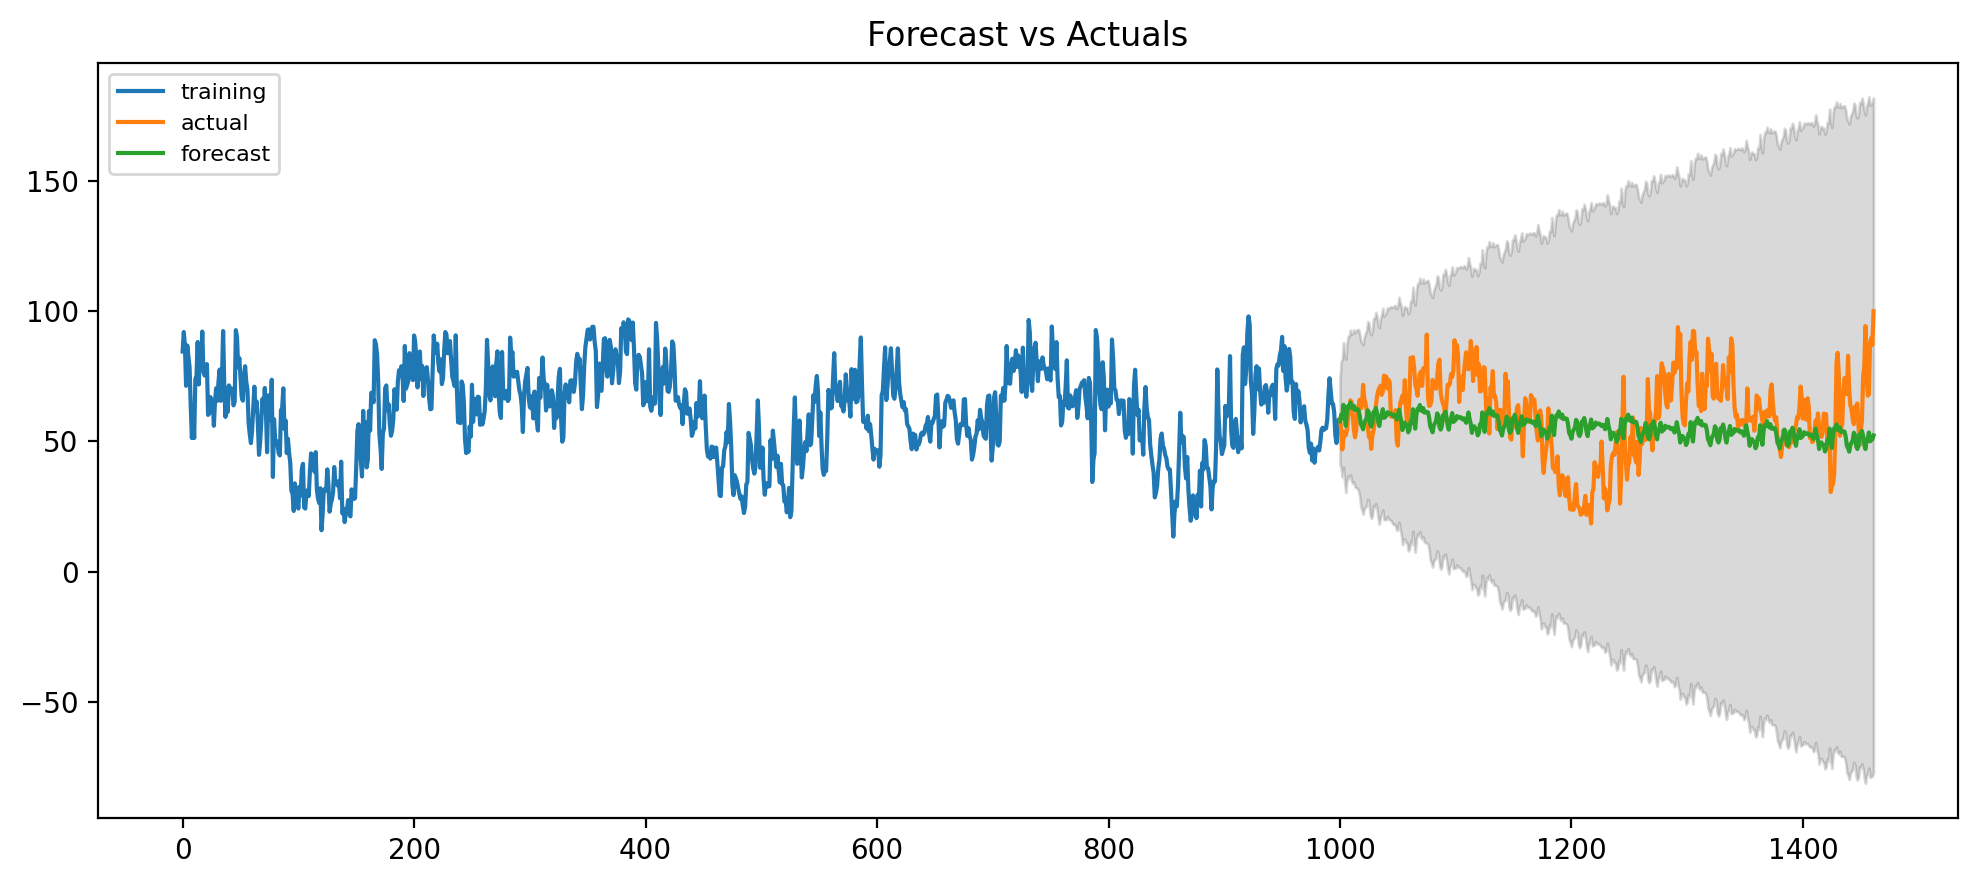

In [6]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(row[:training_time_steps], order=(1, 1, 1), seasonal_order=(1,1,1,60))  
fitted = model.fit()

fc = fitted.get_forecast(len(row[training_time_steps:]))  
conf = fc.conf_int(alpha=0.05) # 95% confidence

fc_series = pd.Series(fc.predicted_mean, index=row[training_time_steps:].index)
lower_series = pd.Series(conf.iloc[:, 0], index=row[training_time_steps:].index)
upper_series = pd.Series(conf.iloc[:, 1], index=row[training_time_steps:].index)

# Plot
plt.figure(figsize=(12,5), dpi=200)
plt.plot(row[:training_time_steps], label='training')
plt.plot(row[training_time_steps:], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [7]:
sequence_length = 30
X = []
y = []
time_steps = len(row)
for i in range(time_steps - sequence_length):
    sequence = row[i:(i+sequence_length)]
    X.append(sequence)
    y.append(row[i+sequence_length])
X = np.array(X)
y = np.array(y)

In [8]:
import math
time_steps = len(X)
training_time_steps = math.floor(time_steps * 0.7) 
X_train = X[:training_time_steps]
X_test = X[training_time_steps:]
y_train = y[:training_time_steps]
y_test = y[training_time_steps:]

X_train_sequences = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_sequences = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
X_anth = X.reshape(X.shape[0], 1, X.shape[1])

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, losses, metrics, optimizers

regressor = Sequential([layers.LSTM(units = 32, activation = 'relu', input_shape = (1, sequence_length)), layers.Dense(1)])

2022-05-13 14:21:26.555945: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


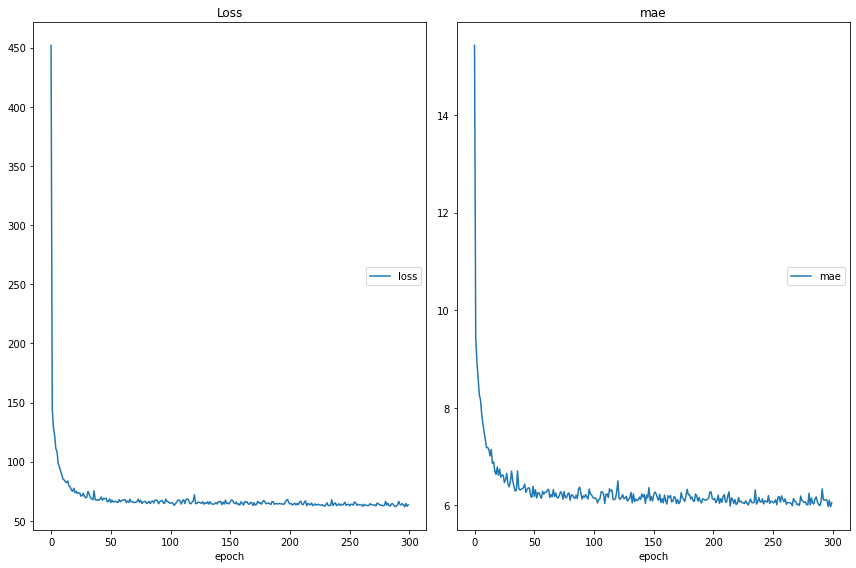

Loss
	loss             	 (min:   61.898, max:  451.865, cur:   63.612)
mae
	mae              	 (min:    5.971, max:   15.424, cur:    6.050)


In [11]:
from livelossplot import PlotLossesKerasTF
regressor.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
history = regressor.fit(X_train_sequences, y_train, batch_size=10, epochs=300, verbose=0, callbacks=[PlotLossesKerasTF()])

In [12]:
y_predicted = regressor.predict(X_test_sequences)

In [13]:
training_sequences = training_time_steps

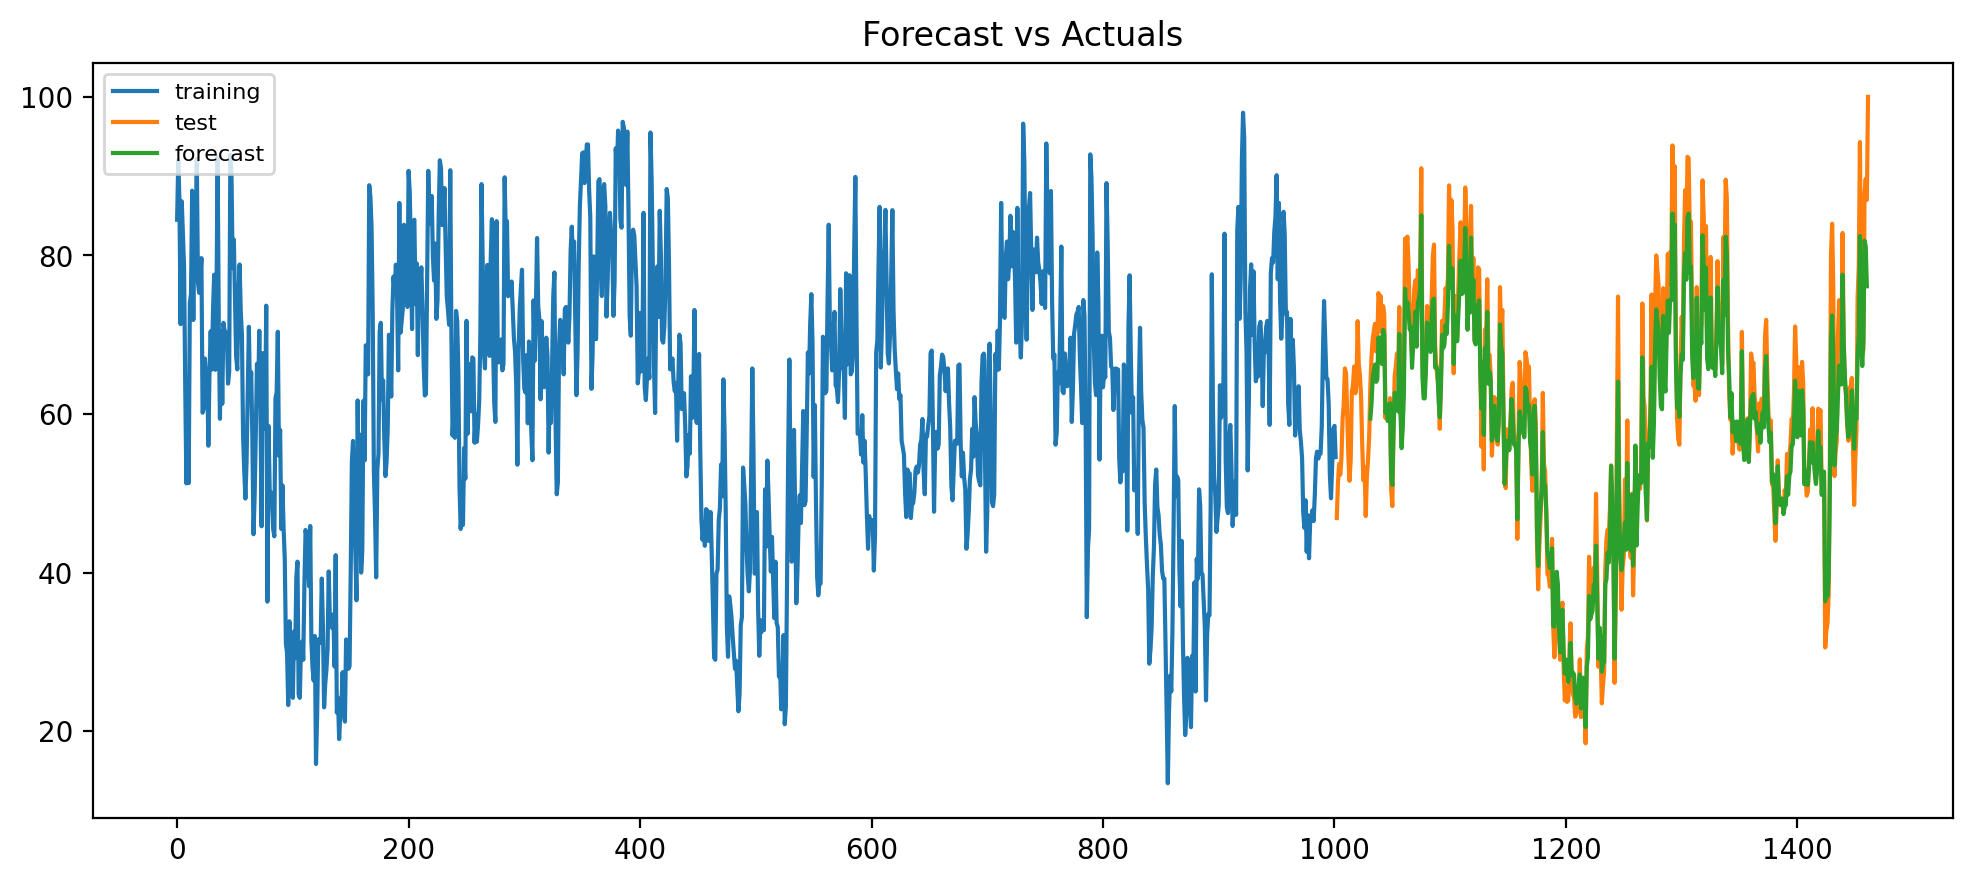

In [15]:
plt.figure(figsize=(12,5), dpi=200) 
plt.plot(range(training_sequences), row[:training_sequences], label='training')
plt.plot(range(training_sequences, len(row)), row[training_sequences:], label='test')
plt.plot(range(1031,1461), y_predicted, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()